# Top - K Sampling Instruct Finetuning.

## 1. Introduction

High-quality data is fundamental to produce a good model in any field. The higher the quality, the better the model. In this notebook, we will create a dataset for finetuning LLM's

![](https://i.imgur.com/IDNhAWH.png)

There are different types of datasets we can use to fine-tune LLMs:

1. **Instruction datasets**: inputs are instructions (e.g., questions) and outputs correspond to the expected responses (e.g., answers). *Example: [Open-Orca](https://huggingface.co/datasets/Open-Orca/OpenOrca).*
2. **Raw completion**: this is a continuation of the pre-training objective (next token prediction). In this case, the trained model is not designed to be used as an assistant. *Example: [MADLAD-400](https://huggingface.co/datasets/allenai/MADLAD-400).*
3. **Preference datasets**: these datasets are used with reinforcement learning to rank candidate responses. They can provide multiple answers to the same instruction, and help the model to select the best response. *Example: [ultrafeedback_binarized](https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized).*
4. **Others**: a fill-in-the-middle objective is very popular with code completion models (e.g., Codex from GitHub Copilot). Other datasets can be designed for classification, where the outputs correspond to the labels we want to predict (the model requires an additional classfication head in this case).

In practice, supervised fine-tuning only leverages the first type of dataset. We can either **create our own** instruction dataset or **modify an existing one** to filter, improve, or enrich it.

## 2. Load and analyze the dataset

In this notebook, we will use a Open Platypus dataset such that translated to Turkish [Open-Platypus](https://huggingface.co/datasets/TR-LLMs/Open-Platypus-TR).

In [1]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

In [2]:
!pip install -q -U transformers datasets accelerate peft trl bitsandbytes wandb

In [3]:
wandb_api = 'c8e706b38b7bd5a60e481e5aebb0a8a949d847ac'

In [4]:
from datasets import load_dataset
import warnings
warnings.simplefilter('ignore')
import os
import argparse
import accelerate
import torch
from trl import SFTTrainer
from datasets import load_dataset
from transformers import TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import wandb
wandb.login(key = wandb_api)
# Load the dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

2024-04-28 10:06:56.631757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 10:06:56.631856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 10:06:56.749935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.ne

Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [5]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


## 3. Tokenizing

For tokenize our dataset, we will use SOTA (State of the Art) model by Meta [Llama-3](https://huggingface.co/meta-llama/Meta-Llama-3-8B).


tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


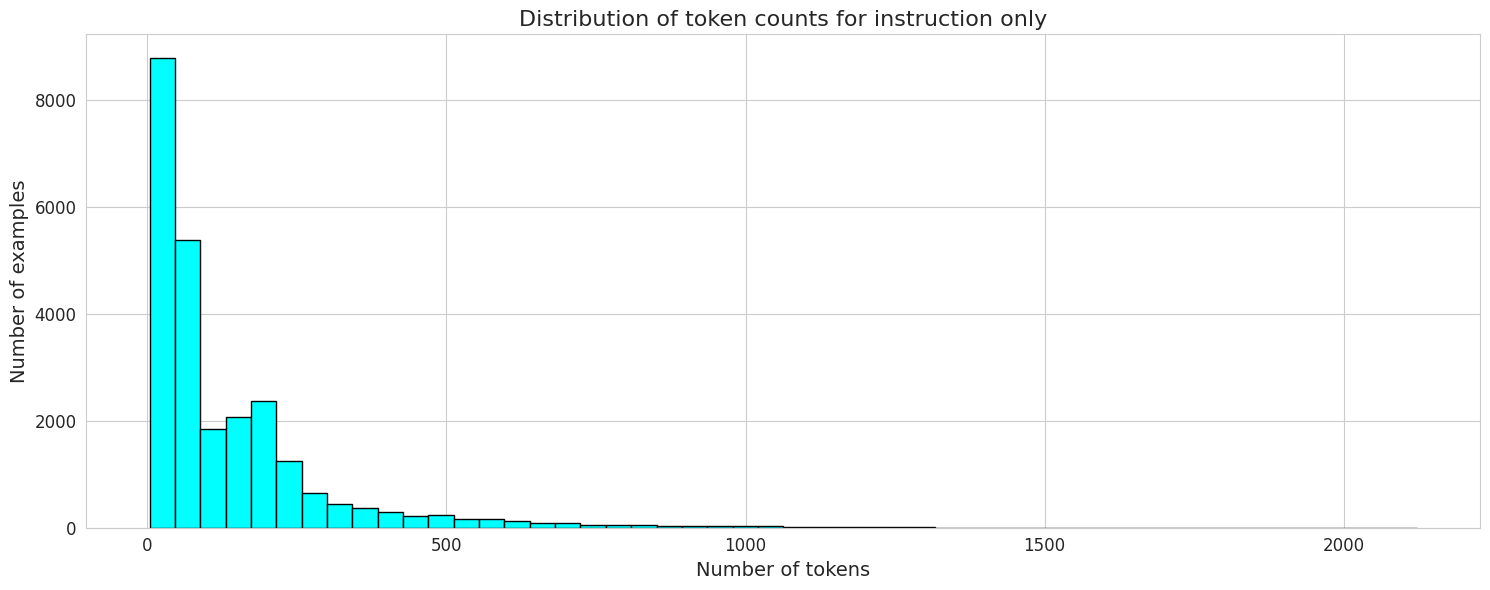

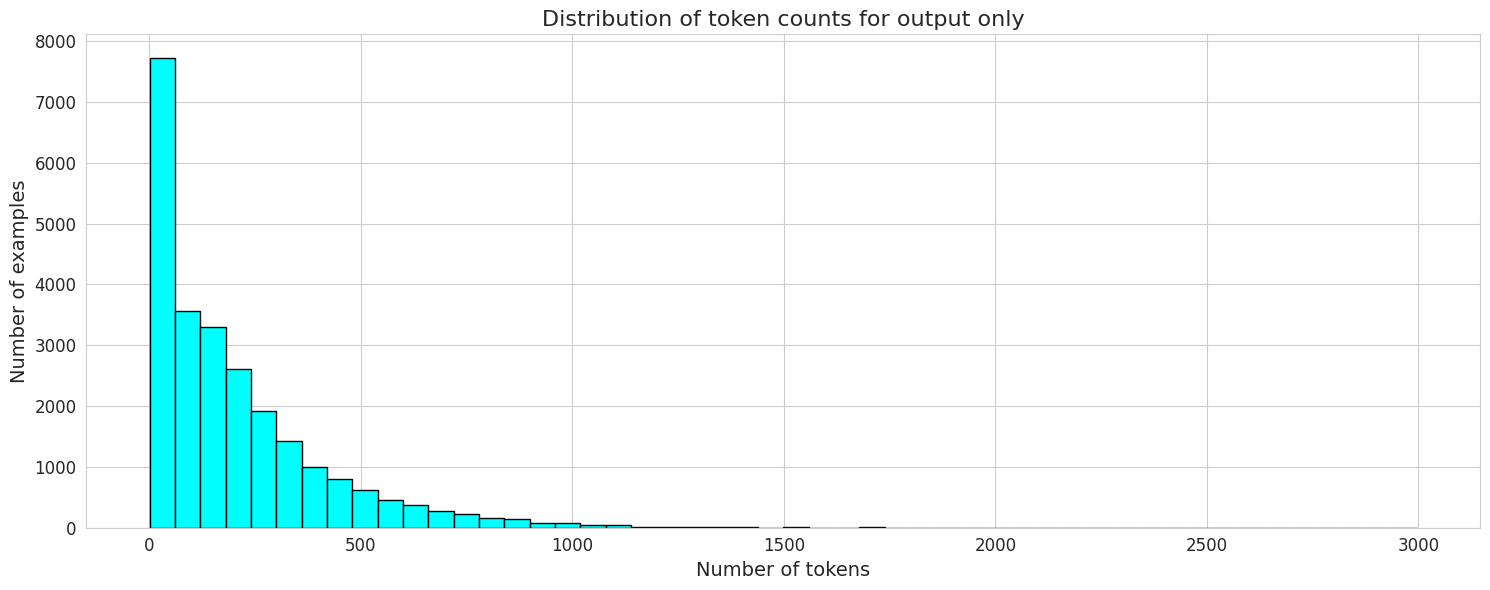

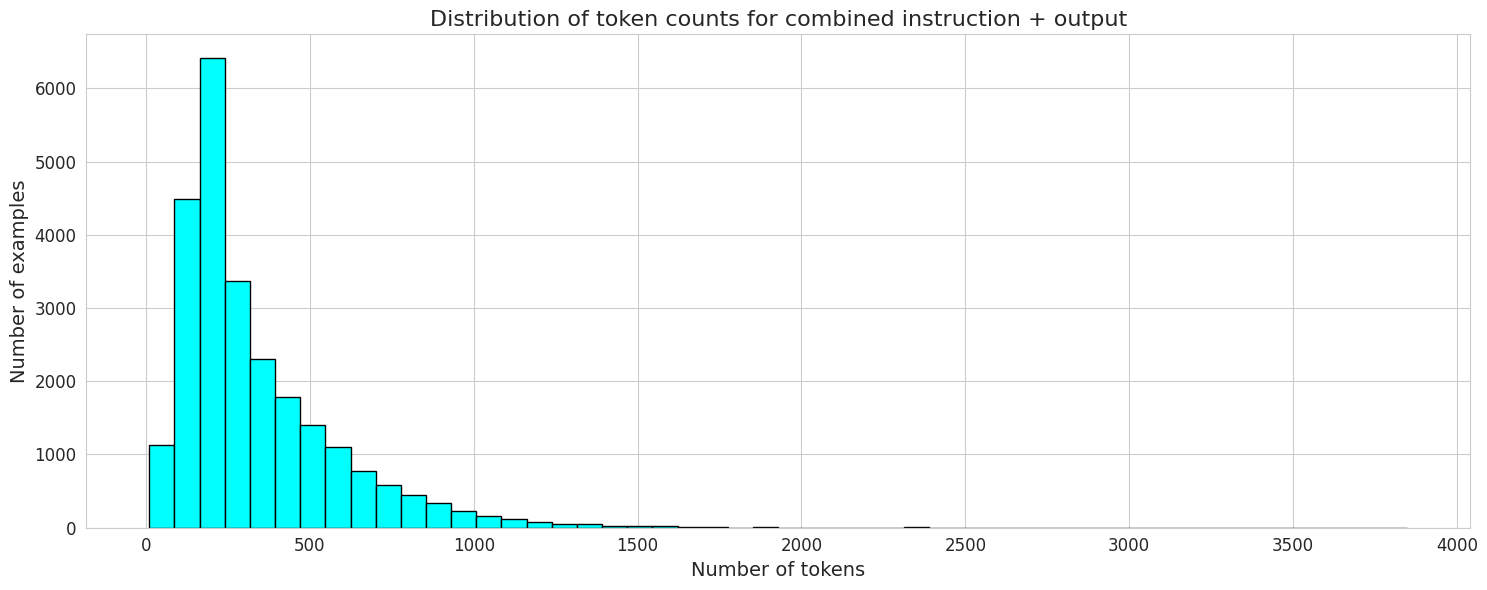

In [6]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Meta-Llama-3-8B")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='cyan', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(title)
    plt.tight_layout()
    plt.show()


# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

As we can see, our data is skewed. This can result in missing data or incorrect answers when we attempt to fine-tune.

## 4. Filter out rows with more than 1024 tokens

To address this issue, we will remove samples with more than 2048 tokens, which aligns with the default maximum context size of Llama 3 (8192 tokens).

Number of valid rows: 24377
Removing 549 rows...


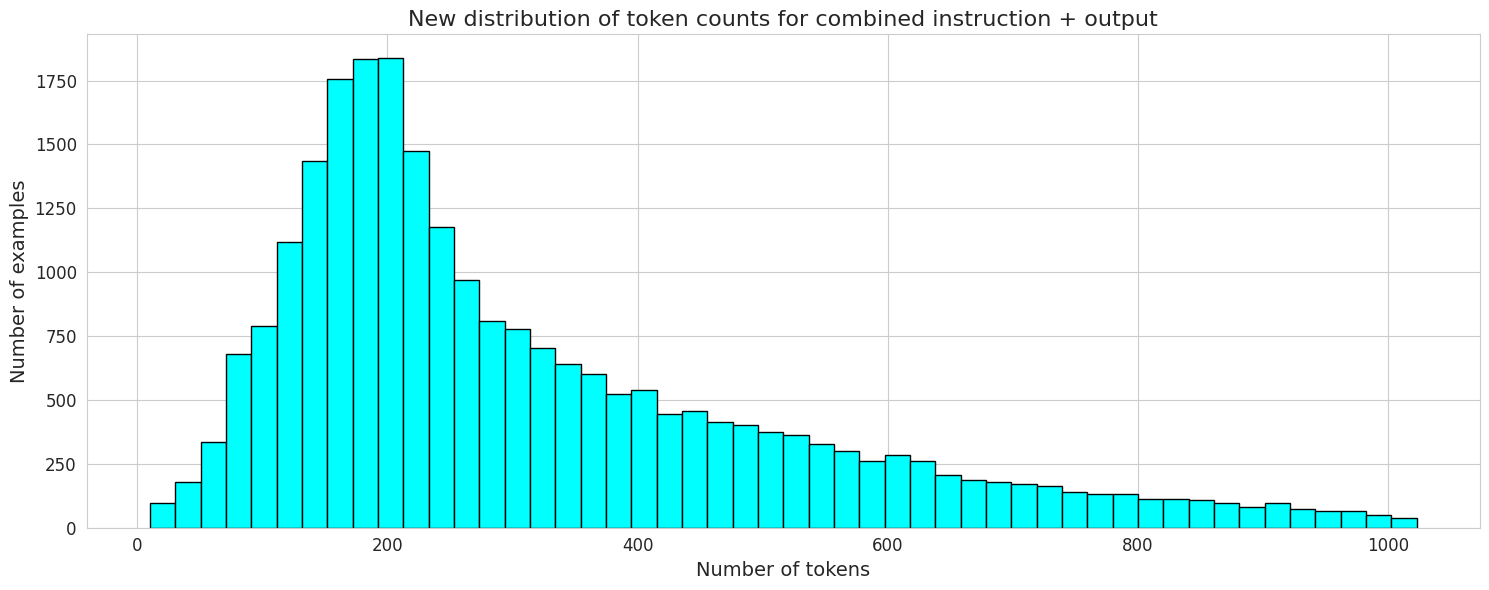

In [7]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 1024]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

## 4. Near-deduplication using embeddings

Algorithm:
 * The function primarily utilizes cosine similarity to determine near-duplicates comparing the cosine similarity between each embedding and its nearest neighbor against a threshold.

$$
\cos (\theta ) =   \dfrac {A \cdot B} {\left\| A\right\| _{2}\left\| B\right\| _{2}}
$$

* While the Faiss library is employed for efficient similarity search, the actual similarity computation relies on cosine similarity rather than k-nearest neighbors.

$$
\ d(\mathbf{p}, \mathbf{q}) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \cdots + (q_n - p_n)^2} \
$$

![](https://media.geeksforgeeks.org/wp-content/uploads/20200616145419/Untitled2781.png)



In [8]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

In [9]:
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/762 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/24377 [00:00<?, ?it/s]

In [10]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 24377
Number of samples in the deduped dataset: 17705
Number of samples that were removed: 6672


## 5. Top-k sampling

Only keep the top k samples with the most tokens.

In [11]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 500  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

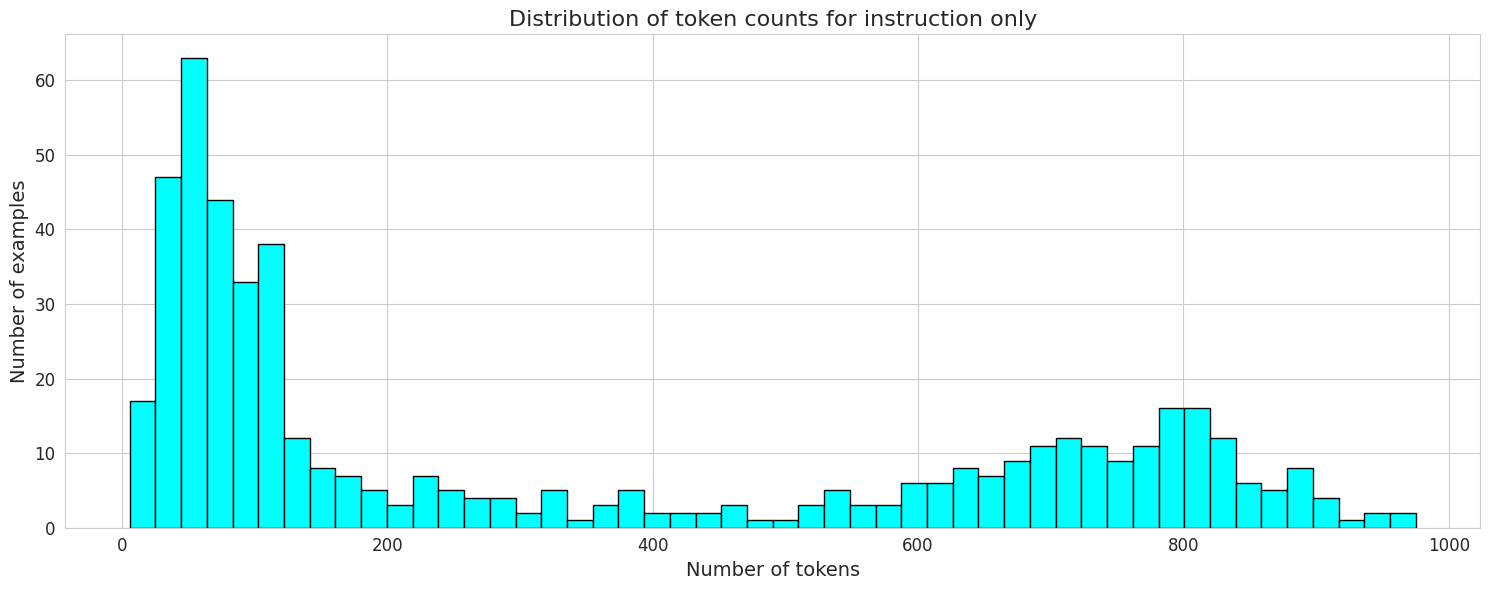

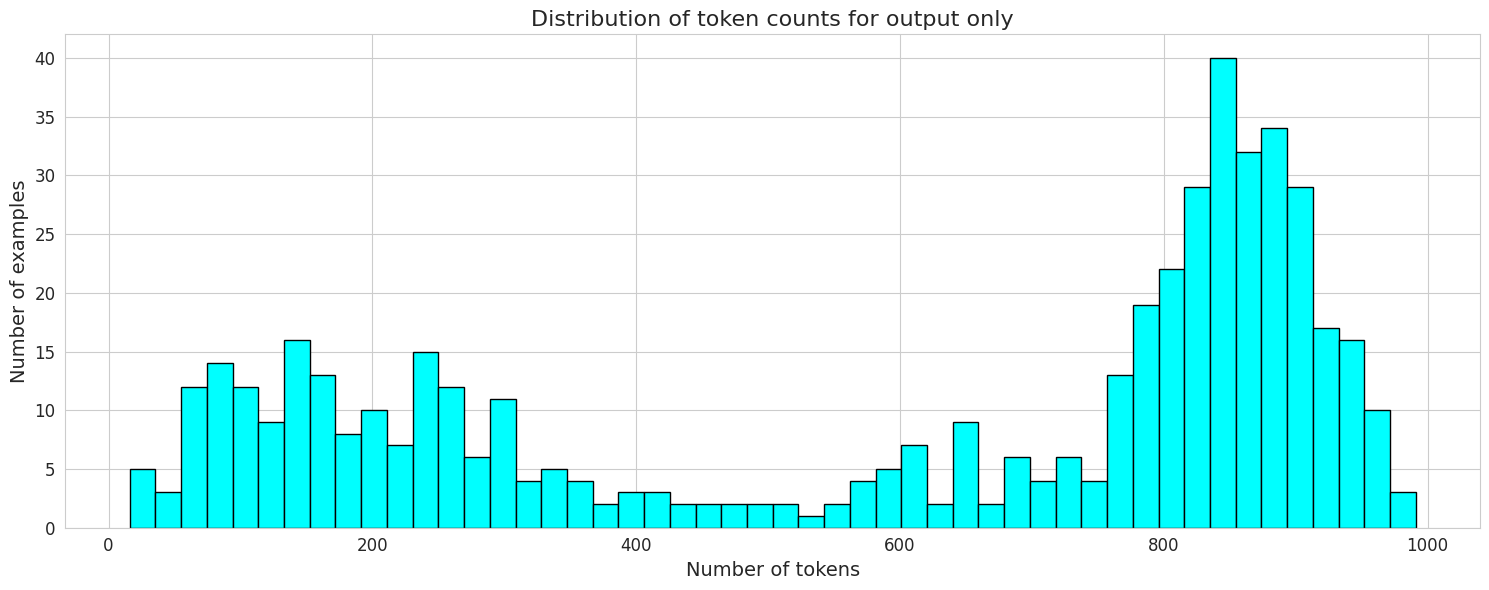

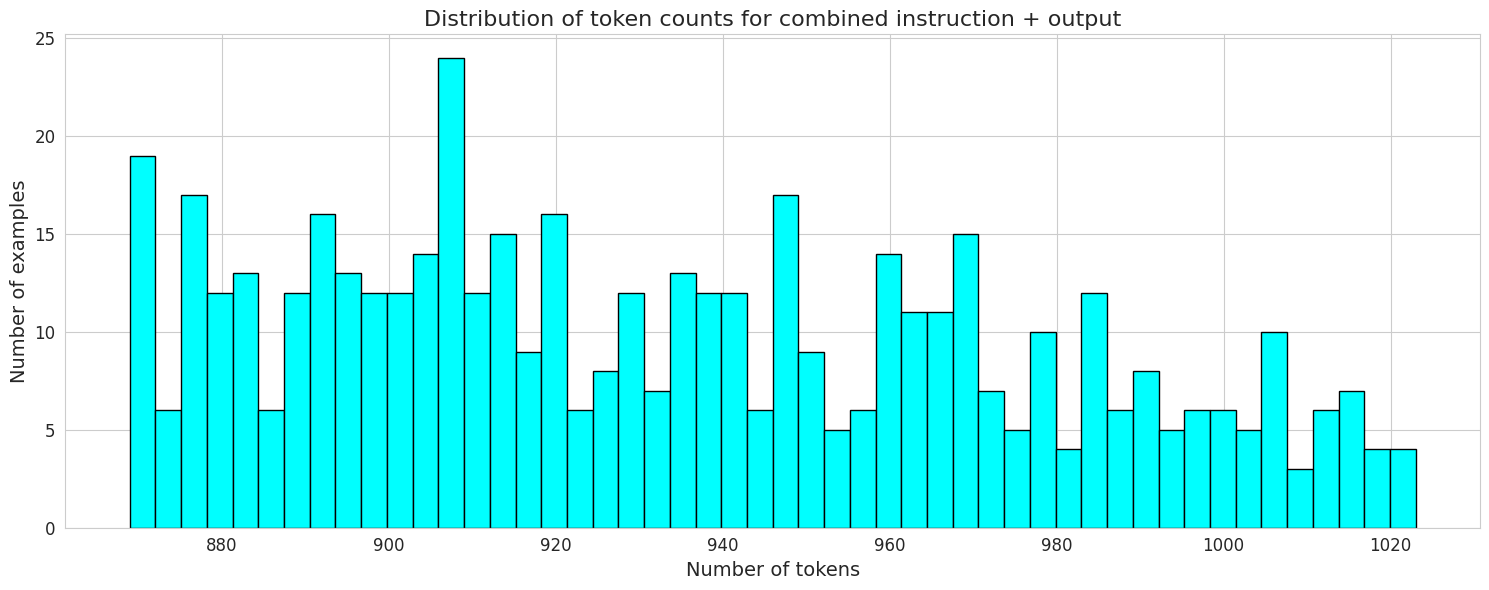

In [12]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 500
    })
})

# Sampled Training

In [14]:
dataset = dataset #sampled
#change datasets for sampled/unsampled dataset
#dataset = load_dataset("garage-bAInd/Open-Platypus") unsampled
base_model = 'ytu-ce-cosmos/turkish-gpt2-large'
model_name = 'cosmos-finetuned'
model_id = base_model

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")



def format_instruction(sample):
    return f"""Sen cevap vermeyi seven yardımcı bir dil modelisin.
        ### Input:
        {sample["instruction"]}

        ### Response:
        {sample["output"]}
    """

In [16]:
# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16)


model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             use_cache=False,
                                             device_map="auto")

config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [17]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1280, out_features=3840, bias=True)
          (c_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1280, out_features=5120, bias=True)
          (c_proj): Linear4bit(in_features=5120, out_features=1280, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, element

In [18]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/585k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [19]:
# LoRA config based on QLoRA paper
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=['c_proj',
                    'c_fc',
                    'gate_proj',
                    'c_proj',
                    'c_attn'],
    bias="lora_only",
    use_rslora=True,
    fan_in_fan_out=True,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)


# prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)


# print the number of trainable model params
print_trainable_parameters(model)

trainable params: 12211200 || all params: 431932160 || trainable%: 2.827110627743023


In [20]:
training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_steps=1,
    optim="paged_adamw_8bit",
    learning_rate=2e-4,
    lr_scheduler_type="linear",
    warmup_steps=10,
    report_to="wandb",
    #max_steps=25, # Remove this line for a real fine-tuning
)
model_args = TrainingArguments(
    output_dir="cosmos-deneme-22/04(0)",
    num_train_epochs=5,
    per_device_train_batch_size=10,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    optim="paged_lion_8bit",
    logging_steps=11,
    save_strategy="epoch",
    learning_rate=2e-4,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="linear",
    disable_tqdm=False,
    #max_steps=10 # disable line for full time training 
)

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset['train'],
    #peft_config=peft_config,
    max_seq_length=20,
    tokenizer=tokenizer,
    #packing=True,
    dataset_text_field="instruction",
    #formatting_func=format_instruction,
    args=model_args,
)



# train
trainer.train()
#trainer.model.save_pretrained(new_model)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

wandb: Currently logged in as: arda-orcun (data-leak). Use `wandb login --relogin` to force relogin


Step,Training Loss
11,4.050700
22,2.836900
33,2.359500
44,2.525900
55,2.032500
66,1.930600
77,1.739700
88,1.883400
99,1.839300
110,1.225900


TrainOutput(global_step=250, training_loss=1.5050346851348877, metrics={'train_runtime': 156.1562, 'train_samples_per_second': 16.01, 'train_steps_per_second': 1.601, 'total_flos': 216056064000000.0, 'train_loss': 1.5050346851348877, 'epoch': 5.0})